In [1]:
import torch
import weightwatcher
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/scratch/connectome/stellasybae/divfreqBERT/') 
from model import *
import argparse

In [9]:
def get_arguments():
    """
    handle arguments from commandline.
    some other hyper parameters can only be changed manually (such as model architecture,dropout,etc)
    notice some arguments are global and take effect for the entire three phase training process, while others are determined per phase
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--exp_name', type=str,default="baseline") 
    parser.add_argument('--dataset_name', type=str, choices=['HCP1200', 'ABCD', 'ABIDE', 'UKB'], default="ABCD")
    parser.add_argument('--gaussian_blur', action='store_true') 
    parser.add_argument('--fmri_type', type=str, choices=['timeseries', 'frequency', 'divided_timeseries', 'divided_frequency', 'time_domain_low', 'time_domain_ultralow', 'time_domain_high' , 'frequency_domain_low', 'frequency_domain_ultralow', 'timeseries_and_frequency'], default="timeseries")
    parser.add_argument('--intermediate_vec', type=int, choices=[84, 48, 22, 180, 200], default=180)
    parser.add_argument('--fmri_timeseries_path', default='/storage/bigdata/ABCD/fmriprep/1.rs_fmri/5.ROI_DATA') ## labserver
    parser.add_argument('--ukb_path', default='/scratch/connectome/stellasybae/UKB_ROI') ## labserver
    parser.add_argument('--abide_path', default='/global/cfs/projectdirs/m4244/stella/ABIDE/3.ROI_DATA') ## perlmutter
    parser.add_argument('--step', default='1', choices=['1','2','3', '4', '5'], help='which step you want to run')
    
    
    parser.add_argument('--target', type=str, default='sex', choices=['sex','age','ASD_label','ADHD_label','nihtbx_totalcomp_uncorrected','nihtbx_fluidcomp_uncorrected', 'ADHD_label_robust', 'SuicideIdeationtoAttempt', 'BMI', 'ASD', 'ASD_label', 'reconstruction'],help='fine_tune_task must be specified as follows -- {sex:classification, age:regression, ASD_label (ABCD) or ASD (ABIDE) :classification, ADHD_label:classification, nihtbx_***:regression}')
    parser.add_argument('--fine_tune_task',
                        choices=['regression','binary_classification'],
                        help='fine tune model objective. choose binary_classification in case of a binary classification task')
    parser.add_argument('--label_scaling_method', default = 'standardization', choices=['standardization', 'minmax'])
    parser.add_argument('--seed', type=int, default=1)
    parser.add_argument('--visualization', action='store_true')
    
    #parser.add_argument('--num_val_samples', type=int, default=10) #100000이 default. 변화 없음.
    parser.add_argument('--norm_axis', default=1, type=int, choices=[0,1,None])
    
    parser.add_argument('--cuda', default=True)
    
    #parser.add_argument('--intensity_factor', default=1)
    #parser.add_argument('--former_transformer_hidden_layers', type=int,default=4)
    parser.add_argument('--transformer_hidden_layers', type=int,default=8)
    

    parser.add_argument('--train_split', default=0.7)
    parser.add_argument('--val_split', default=0.15)
    parser.add_argument('--running_mean_size', default=5000)

    
    # DDP configs:
    parser.add_argument('--world_size', default=-1, type=int, 
                        help='number of nodes for distributed training')
    parser.add_argument('--rank', default=-1, type=int, 
                        help='node rank for distributed training')
    parser.add_argument('--local_rank', default=-1, type=int, 
                        help='local rank for distributed training')
    parser.add_argument('--dist_backend', default='nccl', type=str, 
                        help='distributed backend')
    parser.add_argument('--init_method', default='file', type=str, choices=['file','env'], help='DDP init method')
    parser.add_argument('--non_distributed', action='store_true')
    parser.add_argument('--distributed', default=False)

    # AMP configs:
    parser.add_argument('--amp', action='store_false')
    parser.add_argument('--gradient_clipping', action='store_true')
    parser.add_argument('--clip_max_norm', type=float, default=1.0)
    
    # Gradient accumulation
    parser.add_argument("--accumulation_steps", default=1, type=int,required=False,help='mini batch size == accumulation_steps * args.train_batch_size')
    
    # Nsight profiling
    parser.add_argument("--profiling", action='store_true')
    
    # multimodality options
    parser.add_argument('--fmri_multimodality_type', default='three_channels', choices=['cross_attention','two_channels', 'three_channels'])
    parser.add_argument('--compute_pink', action='store_true')
    #wandb related
    parser.add_argument('--wandb_key', default='108101f4b9c3e31a235aa58307d1c6b548cfb54a', type=str,  help='default: key for Stella')
    parser.add_argument('--wandb_mode', default='online', type=str,  help='online|offline')
    ## divfreqBERT
    # Model Options
    #parser.add_argument('--feature_map_gen', default='no', choices=['convolution_ul+l','convolution_ul', 'no', 'resample'], help='how to generate feature map: convolution_ul+l|convolution_ul|no')
    #parser.add_argument('--feature_map_size', default='same', choices=['same','different'], help='size of feature map: same|different')
    #parser.add_argument('--mixing', default='U2L_and_L2U', choices=['U2L_and_L2U', 'U2L', 'L2U'], help='choose model for mixing lowfrq and ultralowfreq: U2L_and_L2U|U2L|L2U')
    #parser.add_argument('--concat_method', default='concat', choices=['concat','hadamard'], help='size of feature map: concat|hadamard')
    parser.add_argument('--filtering_type', default='Boxcar', choices=['FIR', 'Boxcar'])
    # In case of three channels,
        # if FIR, high-lows : Boxcar, low-ultralow : FIR
        # elif Boxcar, high-lows : Boxcar, low-ultralow : Boxcar
    parser.add_argument('--use_high_freq', action='store_true')
    #parser.add_argument('--final_hidden_dim', type=int, default=20)
    #parser.add_argument('--use_final_hidden_dim', action='store_true')
    parser.add_argument('--embedding_integration_method', type=str, choices=['concat','attention', 'average', 'gap'], default='average')
    parser.add_argument('--parameter_sharing', action='store_true') # temporal
    parser.add_argument('--parameter_sharing_for_spatial_attention', action='store_true') # spatial
    parser.add_argument('--no_parameter_sharing_for_classifier', action='store_true')
    parser.add_argument('--dropout_on_output', action='store_true')
    parser.add_argument('--norm_location', default='post', choices=['pre', 'post'])
    parser.add_argument('--norm_type', default='batch', choices=['batch', 'group', 'layer', 'instance'])                   

    
    # dividing rationale
    parser.add_argument('--divide_by_lorentzian', action='store_true')
    parser.add_argument('--use_raw_knee', action='store_true')
    parser.add_argument('--seq_part', type=str, default='tail')
    parser.add_argument('--use_three_channels', action='store_true')
    parser.add_argument('--use_spatial_attention_map', action='store_true')
    
    # Dropouts
    parser.add_argument('--attn_dropout', type=float, default=0.1,
                        help='attention dropout')
    parser.add_argument('--attn_dropout_u', type=float, default=0.0,
                        help='attention dropout (for ultralow)')
    parser.add_argument('--relu_dropout', type=float, default=0.1,
                        help='relu dropout')
    parser.add_argument('--embed_dropout', type=float, default=0.25,
                        help='embedding dropout')
    parser.add_argument('--res_dropout', type=float, default=0.1,
                        help='residual block dropout')
    parser.add_argument('--out_dropout', type=float, default=0.0,
                        help='output layer dropout')

    # Architecture
    parser.add_argument('--nlevels', type=int, default=12,
                        help='number of layers in the network (default: 12)')
    parser.add_argument('--num_heads_mult', type=int, default=12,
                        help='number of heads for the mutlimodal transformer network (default: 12)')
    parser.add_argument('--num_heads_spatial', type=int, default=12,
                        help='number of heads for the spatial transformer network (default: 12)')
    parser.add_argument('--attn_mask', action='store_false',
                        help='use attention mask for Transformer (default: true)')
    
    
    ## for finetune
    parser.add_argument('--pretrained_model_weights_path', default=None)
    parser.add_argument('--finetune', action='store_true')
    
    ##phase 1 2DBERT
    parser.add_argument('--task_phase1', type=str, default='2DBERT')
    parser.add_argument('--batch_size_phase1', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--validation_frequency_phase1', type=int, default=10000000)
    parser.add_argument('--nEpochs_phase1', type=int, default=20)
    parser.add_argument('--augment_prob_phase1', default=0)
    parser.add_argument('--optim_phase1', default='AdamW')
    parser.add_argument('--weight_decay_phase1', type=float, default=1e-5)
    parser.add_argument('--lr_policy_phase1', default='step', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase1', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase1', type=float, default=0.97)
    parser.add_argument('--lr_step_phase1', type=int, default=500)
    parser.add_argument('--lr_warmup_phase1', type=int, default=500)
    parser.add_argument('--sequence_length', type=int ,default=464) # ABCD & ABIDE 368 HCP 1200
    parser.add_argument('--workers_phase1', type=int,default=4)
    parser.add_argument('--num_heads_2DBert', type=int, default=12)
    parser.add_argument('--feature_squeeze', default=False)
    parser.add_argument('--transformer_dropout_rate', type=float, default=0.3) 
    parser.add_argument('--spatial', action = 'store_true') # for phase 1 
    parser.add_argument('--spatiotemporal', action = 'store_false') # for phase 1 
    parser.add_argument('--spatiotemporal_type', type=str, default='another_stream', choices=['another_stream', 'matrix_multiplication', 'spatial_attention'])
    parser.add_argument('--spat_diff_loss_type', type=str, default='minus_log', choices=['minus_log', 'reciprocal_log', 'exp_minus', 'log_loss', 'exp_whole'])
    parser.add_argument('--spatial_loss_factor', type=float, default=0.1)
    
    
    parser.add_argument('--different_window_size', action = 'store_true')
    parser.add_argument('--weighted_sum', action = 'store_true')
    parser.add_argument('--spatial_model', type=str, default='vit', choices=['vit', 'beit', 'swin', 'swinv2', 'mlp', 'gnn', 'spatialbert'])
    parser.add_argument('--merged_and_averaged', action = 'store_true')
    parser.add_argument('--merge_spatial_and_average_whole', action = 'store_true')
    parser.add_argument('--cross_att_and_average_whole', action = 'store_true')
    parser.add_argument('--additional_logit_merger', action = 'store_true') # 180 -> 1 하고 1들을 oconcat해서 또 regression 
    parser.add_argument('--cross_att_query', type=str, default='temporal', choices=['temporal', 'spatial', 'both'])

    parser.add_argument('--spatial_dim', type=int, default=180, help='final dimension size of VIT for spatial attention')
    parser.add_argument('--when_add_cls', type=str, default='early', choices=['early', 'late'])
    parser.add_argument('--sep_token_computation', action = 'store_true') # 정확히 말하면 nn으로 이거또한 예측의 범주에 넣는거..
    parser.add_argument('--use_sep_token', action = 'store_true')
    parser.add_argument('--init_sep_ratio', type=float, default=0.1)
    
    ##phase 2 lowfreqBERT
    parser.add_argument('--task_phase2', type=str, default='divfreqBERT')
    
    parser.add_argument('--batch_size_phase2', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples') #이걸.. 잘게 쪼개볼까? 원래는 4였음.
    parser.add_argument('--validation_frequency_phase2', type=int, default=10000000) # 11 for test #original: 10000) #원래는 1000이었음 -> 약 7분 걸릴 예정.
    parser.add_argument('--nEpochs_phase2', type=int, default=20) #epoch는 10개인 걸로~
    parser.add_argument('--augment_prob_phase2', default=0)
    parser.add_argument('--optim_phase2', default='AdamW')
    parser.add_argument('--weight_decay_phase2', type=float, default=1e-5) # 원래는 1e-7이었음!
    parser.add_argument('--lr_policy_phase2', default='step', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase2', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase2', type=float, default=0.97)
    parser.add_argument('--lr_step_phase2', type=int, default=500)
    parser.add_argument('--lr_warmup_phase2', type=int, default=500)
    parser.add_argument('--sequence_length_phase2', type=int ,default=368) # 원래는 1이었음~
    parser.add_argument('--workers_phase2', type=int, default=4)
    parser.add_argument('--low_ultralow_rate', type=float, default=0.1) # embedding 단에서
    parser.add_argument('--trainable_low_ultralow_rate', action = 'store_true') # embedding 단에서 trainable 여부 결정
    parser.add_argument('--spatial_temporal_rate', type=float, default=0.1) # embedding 단에서
    parser.add_argument('--trainable_spatial_temporal_rate', action = 'store_true') # embedding 단에서 trainable 여부 결정
    
    parser.add_argument('--low_ultralow_ratio_input', type=float, default=1) # input 단에서
    parser.add_argument('--spatial_window', type=int, default=10)
    parser.add_argument('--spatial_nn_type', type=str, default='cnn')
    
    ##phase 3 (test)
    parser.add_argument('--task_phase3', type=str, default='test')
    parser.add_argument('--model_weights_path_phase2', default=None)
    parser.add_argument('--batch_size_phase3', type=int, default=4)
    parser.add_argument('--nEpochs_phase3', type=int, default=20)
    parser.add_argument('--augment_prob_phase3', default=0)
    parser.add_argument('--optim_phase3', default='AdamW')
    parser.add_argument('--weight_decay_phase3', type=float, default=1e-2)
    parser.add_argument('--lr_policy_phase3', default='step', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase3', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase3', type=float, default=0.9)
    parser.add_argument('--lr_step_phase3', type=int, default=1500)
    parser.add_argument('--lr_warmup_phase3', type=int, default=100)
    parser.add_argument('--sequence_length_phase3', type=int,default=368)
    parser.add_argument('--workers_phase3', type=int, default=4)
    
    ##phase 4 2DBERT reconstruction
    parser.add_argument('--task_phase4', type=str, default='2DBERT_reconstruction')
    parser.add_argument('--batch_size_phase4', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--validation_frequency_phase4', type=int, default=10000000)
    parser.add_argument('--nEpochs_phase4', type=int, default=20)
    parser.add_argument('--augment_prob_phase4', default=0)
    parser.add_argument('--optim_phase4', default='AdamW')
    parser.add_argument('--weight_decay_phase4', type=float, default=1e-5)
    parser.add_argument('--lr_policy_phase4', default='step', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase4', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase4', type=float, default=0.97)
    parser.add_argument('--lr_step_phase4', type=int, default=500)
    parser.add_argument('--lr_warmup_phase4', type=int, default=500)
    parser.add_argument('--sequence_length_phase4', type=int ,default=368) # ABCD 368 HCP 1200
    parser.add_argument('--workers_phase4', type=int,default=4)

    parser.add_argument('--use_cont_loss', action='store_true') # for phase 4 and 5
    parser.add_argument('--single_ROI', action='store_true') # for phase 4 and 5
    
    ##phase 5 divfreqBERT reconstruction
    parser.add_argument('--task_phase5', type=str, default='divfreqBERT_reconstruction')
    parser.add_argument('--batch_size_phase5', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples')
    parser.add_argument('--validation_frequency_phase5', type=int, default=10000000)
    parser.add_argument('--nEpochs_phase5', type=int, default=20)
    parser.add_argument('--augment_prob_phase5', default=0)
    parser.add_argument('--optim_phase5', default='AdamW')
    parser.add_argument('--weight_decay_phase5', type=float, default=1e-5)
    parser.add_argument('--lr_policy_phase5', default='step', help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase5', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase5', type=float, default=0.97)
    parser.add_argument('--lr_step_phase5', type=int, default=500)
    parser.add_argument('--lr_warmup_phase5', type=int, default=500)
    parser.add_argument('--sequence_length_phase5', type=int ,default=368) # ABCD 368 HCP 1200
    parser.add_argument('--workers_phase5', type=int,default=4)
    parser.add_argument('--use_recon_loss', action='store_true') # for phase 4 and 5
    parser.add_argument('--use_mask_loss', action='store_true') # for phase 4 and 5
    parser.add_argument('--masking_rate', type=float, default=0.1) # for phase 4 and 5
    parser.add_argument('--masking_method', type=str, default='temporal', choices=['temporal', 'spatial', 'spatiotemporal'])
    parser.add_argument('--temporal_masking_type', type=str, default='single_point', choices=['single_point','time_window'])
    parser.add_argument('--temporal_masking_window_size', type=int, default=5)
    parser.add_argument('--window_interval_rate', type=int, default=3)
    parser.add_argument('--spatial_masking_type', type=str, default='hub_ROIs', choices=['hub_ROIs', 'random_ROIs'])
    parser.add_argument('--num_hub_ROIs', type=int, default=5)
    parser.add_argument('--num_random_ROIs', type=int, default=5)
    parser.add_argument('--spatiotemporal_masking_type', type=str, default='whole', choices=['whole', 'separate'])
                        
                        
                        
                        
    args = parser.parse_args(args=[])
        
    return args

In [10]:
args = get_arguments()

In [11]:
args

Namespace(abide_path='/global/cfs/projectdirs/m4244/stella/ABIDE/3.ROI_DATA', accumulation_steps=1, additional_logit_merger=False, amp=True, attn_dropout=0.1, attn_dropout_u=0.0, attn_mask=True, augment_prob_phase1=0, augment_prob_phase2=0, augment_prob_phase3=0, augment_prob_phase4=0, augment_prob_phase5=0, batch_size_phase1=8, batch_size_phase2=8, batch_size_phase3=4, batch_size_phase4=8, batch_size_phase5=8, clip_max_norm=1.0, compute_pink=False, cross_att_and_average_whole=False, cross_att_query='temporal', cuda=True, dataset_name='ABCD', different_window_size=False, dist_backend='nccl', distributed=False, divide_by_lorentzian=False, dropout_on_output=False, embed_dropout=0.25, embedding_integration_method='average', exp_name='baseline', feature_squeeze=False, filtering_type='Boxcar', fine_tune_task=None, finetune=False, fmri_multimodality_type='three_channels', fmri_timeseries_path='/storage/bigdata/ABCD/fmriprep/1.rs_fmri/5.ROI_DATA', fmri_type='timeseries', gaussian_blur=False, 

self.transfer_learning False
self.transfer_learning False


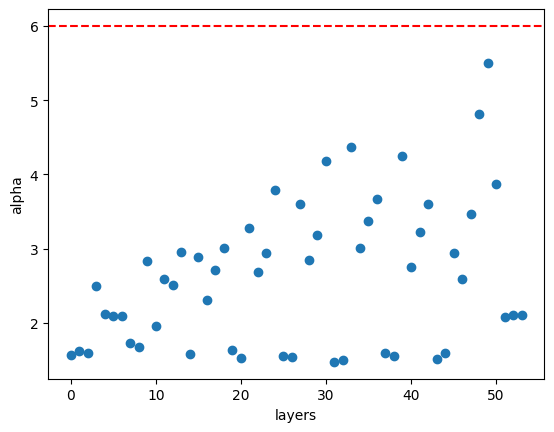

In [13]:
model_path = '../experiments/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_spatiotemporal_model_factor_01_spatiotemporal_mask_window_20_interval_2_num_hub_18_seq_len_464_seed1/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_spatiotemporal_model_factor_01_spatiotemporal_mask_window_20_interval_2_num_hub_18_seq_len_464_seed1_epoch_1000_BEST_val_loss.pth'
model = Transformer_Reconstruction_Three_Channels(**vars(args))
model.load_state_dict(torch.load(model_path, map_location='cuda:0')['model_state_dict'])
model.eval()
watcher = weightwatcher.WeightWatcher(model=model)
details = watcher.analyze()
plt.xlabel('layers')
plt.ylabel('alpha')
plt.axhline(y=6, linestyle='--', color='r')
plt.scatter(range(0, len(details)), details['alpha']) # 엥?
plt.savefig('weightwatcher_spatiotemporal_factor01_temporal20_hub18.pdf', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches=None, 
    pad_inches=0.1,
    metadata=None)

self.transfer_learning False
self.transfer_learning False


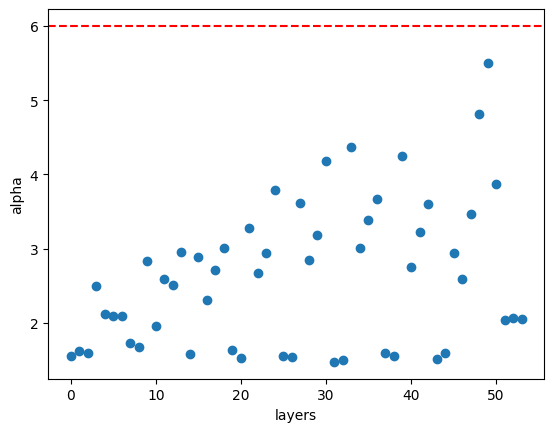

In [14]:
model_path = '../experiments/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_spatiotemporal_model_factor_1_spatiotemporal_mask_window_20_interval_2_num_hub_18_seq_len_464_seed1/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_spatiotemporal_model_factor_1_spatiotemporal_mask_window_20_interval_2_num_hub_18_seq_len_464_seed1_epoch_1000_BEST_val_loss.pth'
model = Transformer_Reconstruction_Three_Channels(**vars(args))
model.load_state_dict(torch.load(model_path, map_location='cuda:0')['model_state_dict'])
model.eval()
watcher = weightwatcher.WeightWatcher(model=model)
details = watcher.analyze()
plt.xlabel('layers')
plt.ylabel('alpha')
plt.axhline(y=6, linestyle='--', color='r')
plt.scatter(range(0, len(details)), details['alpha']) # 엥?
plt.savefig('weightwatcher_spatiotemporal_factor1_temporal20_hub18.pdf', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches=None, 
    pad_inches=0.1,
    metadata=None)

In [20]:
temporal_model_dict = vars(args)
temporal_model_dict['spatiotemporal'] = False

In [21]:
temporal_model_dict['spatiotemporal']

False

self.transfer_learning False
self.transfer_learning False


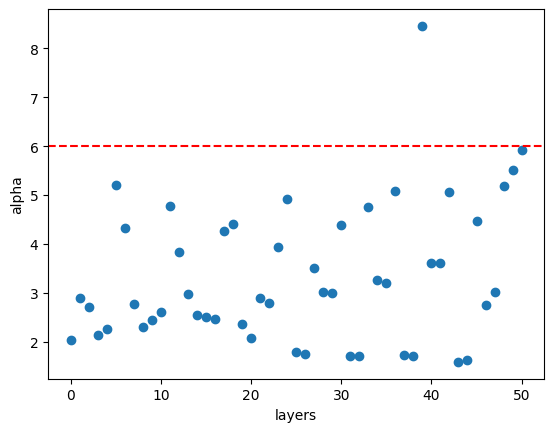

In [26]:
model_path = '../experiments/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_temporal_model_temporal_mask_timewindow_20_timeinterval_2_seq_len_464_epoch1000_seed1/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_temporal_model_temporal_mask_timewindow_20_timeinterval_2_seq_len_464_epoch1000_seed1_epoch_1000_BEST_val_loss.pth'
model = Transformer_Reconstruction_Three_Channels(**temporal_model_dict)
model.load_state_dict(torch.load(model_path, map_location='cuda:0')['model_state_dict'], strict=False)
model.eval()
watcher = weightwatcher.WeightWatcher(model=model)
details = watcher.analyze()
plt.xlabel('layers')
plt.ylabel('alpha')
plt.axhline(y=6, linestyle='--', color='r')
plt.scatter(range(0, len(details)), details['alpha']) # 엥?
plt.savefig('weightwatcher_temporal20.pdf', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches=None, 
    pad_inches=0.1,
    metadata=None)

In [30]:
spatial_model_dict_424 = temporal_model_dict
spatial_model_dict_424['sequence_length'] = 424

self.transfer_learning False
self.transfer_learning False


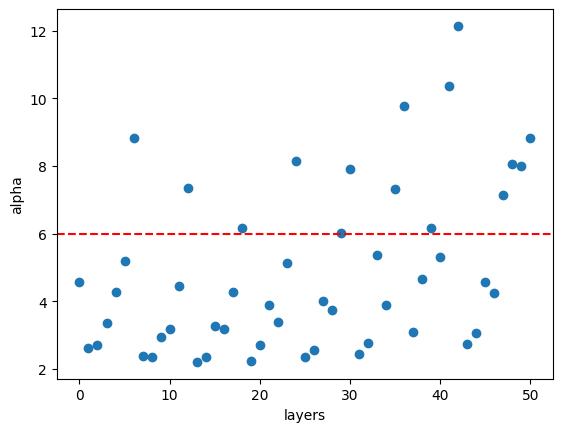

In [31]:
model_path = '../experiments/UKB_divfreqBERT_reconstruction_reconstruction_240124_hid8_head12_tempral_model_spatial_mask_hub_ROIs_170_seed1/UKB_divfreqBERT_reconstruction_reconstruction_240124_hid8_head12_tempral_model_spatial_mask_hub_ROIs_170_seed1_epoch_100_BEST_val_loss.pth'
model = Transformer_Reconstruction_Three_Channels(**spatial_model_dict_424)
model.load_state_dict(torch.load(model_path, map_location='cuda:0')['model_state_dict'], strict=False)
model.eval()
watcher = weightwatcher.WeightWatcher(model=model)
details = watcher.analyze()
plt.xlabel('layers')
plt.ylabel('alpha')
plt.axhline(y=6, linestyle='--', color='r')
plt.scatter(range(0, len(details)), details['alpha']) # 엥?
plt.savefig('weightwatcher_spatial170.pdf', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches=None, 
    pad_inches=0.1,
    metadata=None)

In [34]:
temporal_model_dict['sequence_length'] = 464

self.transfer_learning False
self.transfer_learning False


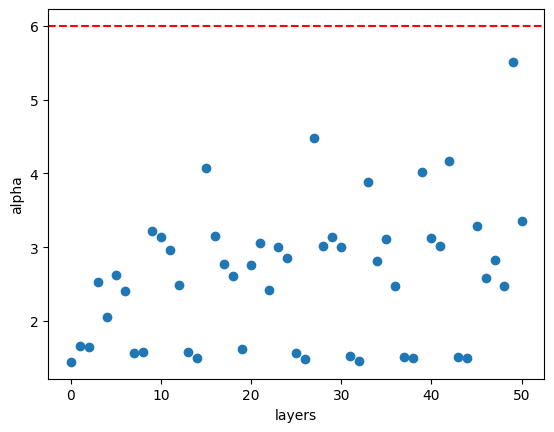

In [35]:
model_path = '../experiments/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_spatial_mask_hub_ROIs_18_seq_len_464_seed1/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_spatial_mask_hub_ROIs_18_seq_len_464_seed1_epoch_1000_BEST_val_loss.pth'
model = Transformer_Reconstruction_Three_Channels(**temporal_model_dict)
model.load_state_dict(torch.load(model_path, map_location='cuda:0')['model_state_dict'], strict=False)
model.eval()
watcher = weightwatcher.WeightWatcher(model=model)
details = watcher.analyze()
plt.xlabel('layers')
plt.ylabel('alpha')
plt.axhline(y=6, linestyle='--', color='r')
plt.scatter(range(0, len(details)), details['alpha']) # 엥?
plt.savefig('weightwatcher_spatial18.pdf', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches=None, 
    pad_inches=0.1,
    metadata=None)

self.transfer_learning False
self.transfer_learning False


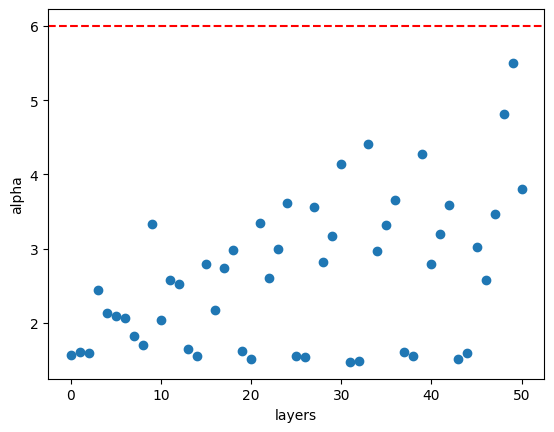

In [38]:
model_path = '../experiments/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_temporal_model_spatiotemporal_mask_window_20_interval_2_num_hub_18_seq_len_464_seed1/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_temporal_model_spatiotemporal_mask_window_20_interval_2_num_hub_18_seq_len_464_seed1_epoch_1000_BEST_val_loss.pth'
model = Transformer_Reconstruction_Three_Channels(**temporal_model_dict)
model.load_state_dict(torch.load(model_path, map_location='cuda:0')['model_state_dict'], strict=False)
model.eval()
watcher = weightwatcher.WeightWatcher(model=model)
details = watcher.analyze()
plt.xlabel('layers')
plt.ylabel('alpha')
plt.axhline(y=6, linestyle='--', color='r')
plt.scatter(range(0, len(details)), details['alpha']) # 엥?
plt.savefig('weightwatcher_temporal20_spatial18.pdf', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches=None, 
    pad_inches=0.1,
    metadata=None)

self.transfer_learning False
self.transfer_learning False


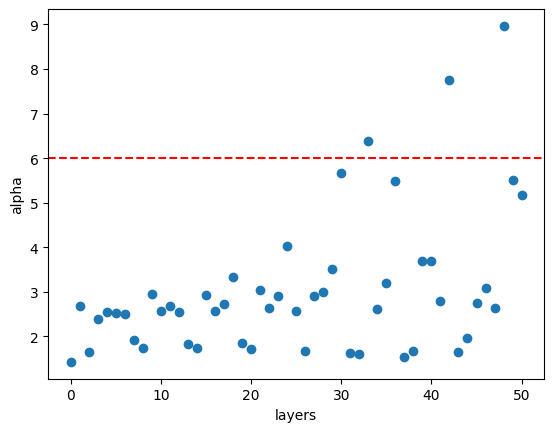

In [39]:
model_path = '../experiments/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_temporal_model_spatiotemporal_mask_window_20_interval_2_num_hub_36_seq_len_464_seed1/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_temporal_model_spatiotemporal_mask_window_20_interval_2_num_hub_36_seq_len_464_seed1_epoch_349_BEST_val_loss.pth'
model = Transformer_Reconstruction_Three_Channels(**temporal_model_dict)
model.load_state_dict(torch.load(model_path, map_location='cuda:0')['model_state_dict'], strict=False)
model.eval()
watcher = weightwatcher.WeightWatcher(model=model)
details = watcher.analyze()
plt.xlabel('layers')
plt.ylabel('alpha')
plt.axhline(y=6, linestyle='--', color='r')
plt.scatter(range(0, len(details)), details['alpha']) # 엥?
plt.savefig('weightwatcher_temporal20_spatial36.pdf', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches=None, 
    pad_inches=0.1,
    metadata=None)

self.transfer_learning False
self.transfer_learning False


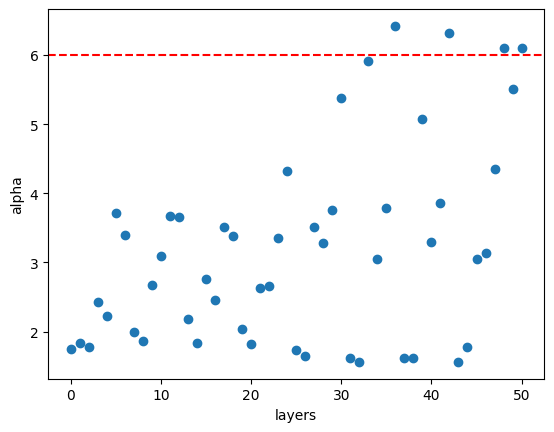

In [40]:
model_path = '../experiments/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_temporal_model_spatiotemporal_mask_window_20_interval_2_num_hub_9_seq_len_464_seed1/UKB_divfreqBERT_reconstruction_reconstruction_240130_hid8_head12_temporal_model_spatiotemporal_mask_window_20_interval_2_num_hub_9_seq_len_464_seed1_epoch_326_BEST_val_loss.pth'
model = Transformer_Reconstruction_Three_Channels(**temporal_model_dict)
model.load_state_dict(torch.load(model_path, map_location='cuda:0')['model_state_dict'], strict=False)
model.eval()
watcher = weightwatcher.WeightWatcher(model=model)
details = watcher.analyze()
plt.xlabel('layers')
plt.ylabel('alpha')
plt.axhline(y=6, linestyle='--', color='r')
plt.scatter(range(0, len(details)), details['alpha']) # 엥?
plt.savefig('weightwatcher_temporal20_spatial9.pdf', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches=None, 
    pad_inches=0.1,
    metadata=None)